In [14]:
import boto3
import botocore
import json
import os
import uuid

glue = boto3.client('glue')
s3 = boto3.resource('s3')
s3_client = boto3.client('s3')
lf = boto3.client('lakeformation')

session = boto3.session.Session()
region = session.region_name
account_id = boto3.client('sts').get_caller_identity().get('Account')

database_name = 'taxi-demo' # AWS Glue Data Catalog Database Name

### [Create S3 Bucket](https://docs.aws.amazon.com/AmazonS3/latest/gsg/CreatingABucket.html)

We will create an S3 bucket that will be used throughout the workshop for storing our data.

[s3.create_bucket](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/s3.html#S3.Client.create_bucket) boto3 documentation

In [4]:
def create_bucket_name(bucket_prefix):
    # The generated bucket name must be between 3 and 63 chars long
    return ''.join([bucket_prefix, str(uuid.uuid4())])

def create_bucket(region, session, bucket_prefix):
    bucket = create_bucket_name(bucket_prefix)
    
    if region != 'us-east-1':
        session.resource('s3').create_bucket(Bucket=bucket, CreateBucketConfiguration={'LocationConstraint': region})
    else:
        session.resource('s3').create_bucket(Bucket=bucket)
    return bucket

bucket = create_bucket(region, session, 'glue-studio-taxi-')

'glue-studio-taxi-be7713e5-c47e-466f-8322-f91db13d1bb1'

### [Copy Sample Data to S3 bucket](https://boto3.amazonaws.com/v1/documentation/api/latest/guide/s3-example-download-file.html)

We will download some files from New York City Taxi and Limousine Commission (TLC) Trip Record Data dataset available on the [AWS Open Data Registry](https://registry.opendata.aws/nyc-tlc-trip-records-pds/)

In [7]:
!aws s3 cp s3://nyc-tlc/trip\ data/yellow_tripdata_2017-01.csv s3://$bucket/datalake/yellow/
!aws s3 cp s3://nyc-tlc/trip\ data/yellow_tripdata_2017-02.csv s3://$bucket/datalake/yellow/

copy: s3://nyc-tlc/trip data/yellow_tripdata_2017-01.csv to s3://glue-studio-taxi-be7713e5-c47e-466f-8322-f91db13d1bb1/datalake/yellow/yellow_tripdata_2017-01.csv
copy: s3://nyc-tlc/trip data/yellow_tripdata_2017-02.csv to s3://glue-studio-taxi-be7713e5-c47e-466f-8322-f91db13d1bb1/datalake/yellow/yellow_tripdata_2017-02.csv


### [Upload to S3](https://docs.aws.amazon.com/AmazonS3/latest/dev/Welcome.html)

Next, we will upload the json files located in the `data` folder to S3 to be used later in the workshop.

[s3.upload_file](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/s3.html#S3.Client.upload_file) boto3 documentation

In [8]:
file_name = 'paymenttype.csv'
path = 'data'
session.resource('s3').Bucket(bucket).Object(os.path.join('datalake', 'paymenttype', file_name)).upload_file(path + '/' + file_name)

file_name = 'ratecode.csv'
session.resource('s3').Bucket(bucket).Object(os.path.join('datalake', 'ratecode', file_name)).upload_file(path + '/' + file_name)

file_name = 'taxi_zone_lookup.csv'
session.resource('s3').Bucket(bucket).Object(os.path.join('datalake', 'taxi_zone_lookup', file_name)).upload_file(path + '/' + file_name)

#### Add LakeFormation Permissions to create databases

In [13]:
# Import SageMaker Python SDK to get the Session and execution_role
import sagemaker
from sagemaker import get_execution_role
sess = sagemaker.Session()
role = get_execution_role()
role_name = role[role.rfind('/') + 1:]
print(role_name)

sage-AmazonSageMaker-ExecutionRole


#### Add role a Data Lake Administrator 

Log into the console and go to AWS Lake Formation -> Permissions -> Admins and database creators and add the role above as a Database Creator

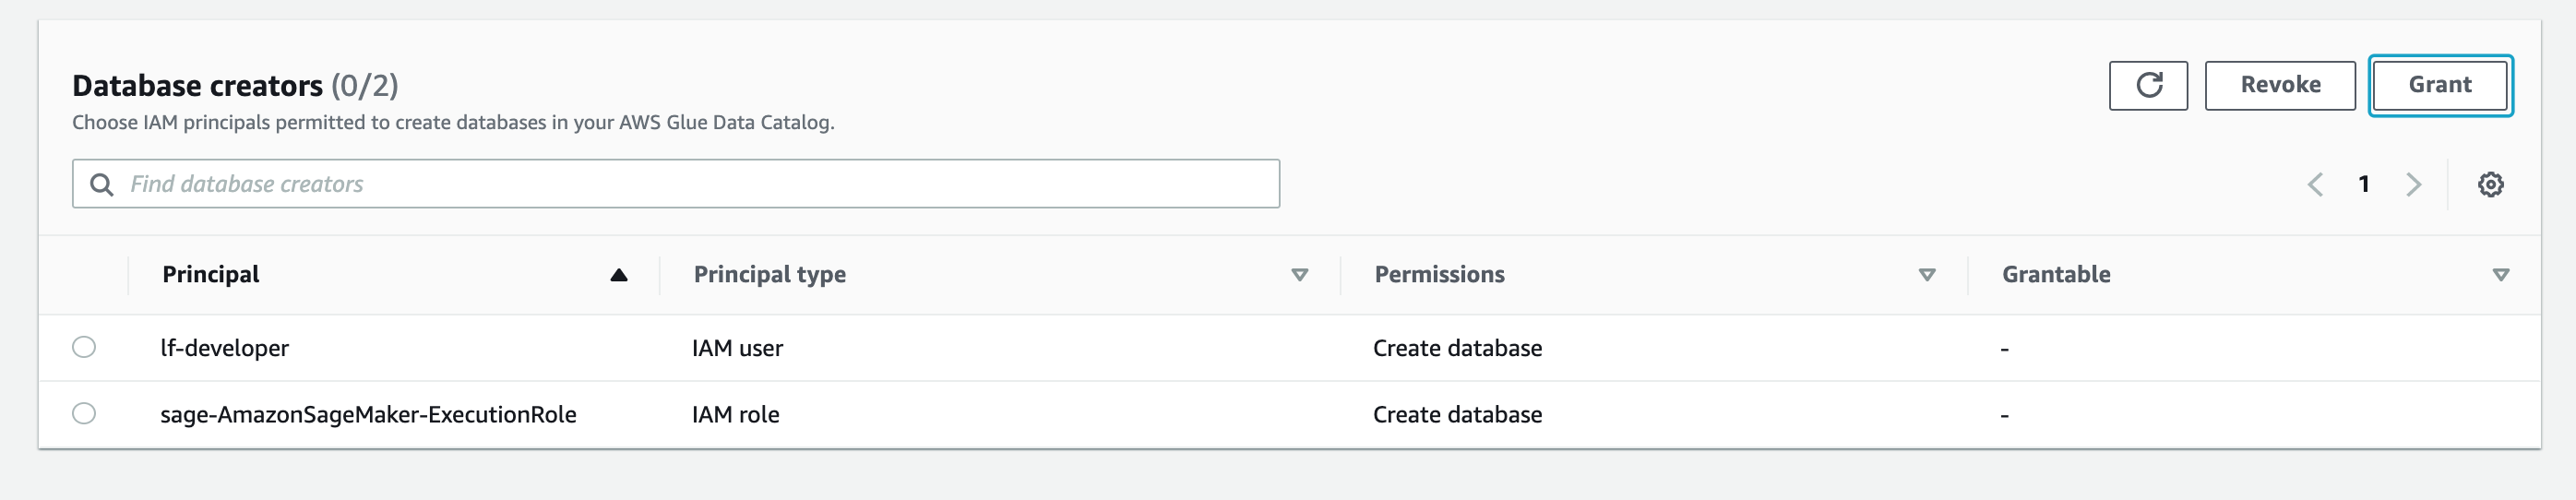

### Create the [AWS Glue Catalog Database](https://docs.aws.amazon.com/glue/latest/dg/define-database.html)

When you define a table in the AWS Glue Data Catalog, you add it to a database. A database is used to organize tables in AWS Glue. You can organize your tables using a crawler or using the AWS Glue console. A table can be in only one database at a time.

There is a central Glue Catalog for each AWS account. When creating the database you will use your account id declared above as `account_id`

[glue.create_database](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/glue.html#Glue.Client.create_database)

In [18]:
def create_db(glue_client, account_id, database_name, description):
    """Create the specified Glue database if it does not exist"""
    try:
        glue_client.get_database(
            CatalogId=account_id,
            Name=database_name
        )
    except glue_client.exceptions.EntityNotFoundException:
        print("Creating database: %s" % database_name)
        glue_client.create_database(
            CatalogId=account_id,
            DatabaseInput={
                'Name': database_name,
                'Description': description
            }
        )

In [19]:
create_db(glue, account_id, database_name, 'New York City Taxi and Limousine Commission (TLC) Trip Record Data')

Creating database: taxi-demo
